# ML001 PREDICTING THE MEDIAN HOUSING PRICES IN CALIFORNIA

## 1. Understanding the Big Picture

In this project, we will undertake a challenging task of building a model of housing prices in California using the 1990 California census data. The data contain metrics like population, median income, median housing price and so on for each block group (or housing "district") in California. Our model will be able to learn from the data and available metrics and predict the median housing price in any Californian housing district. Note: a district here means a block group which typically has a population of 600 to 3,000 people).

### 1.1. The business objective

We have been told by the leadership of our company that our predictions will be fed into another Machine Learning system that will determine whether it is worth investing in a given area or not. This means our model will directly affect the company's revenue, so it's critical that we get it right!

### 1.2. Framing the problem

Before we embark on our challenge, it is crucial that we first understand the problem and what the current solution looks like. This would help us understand how important our model could be if done right. 

Our boss has told us that the current system sucks! District housing prices are estimated manually by 'experts' who estimate the median housing price using complex rules. This is time-consuming and costs a lot of money. To make matters worse, their estimates are not great: they are often off by more than 20%. 

Given that our dataset includes the median housing prices of thousands of districts, it would be great if we could exploit it and train a model for faster and more accurate predictions. We are now ready to frame our problem:
- Is it supervised, unsupervised, or reinforcement learning? Because we are given *labeled* training examples where each instance comes with the expected output, i.e., the disctrict's median housing price, that means it's a typical **supervised machine learning** task.


- Is it a classification task, a regression task, or something else? It is a **regression** task because we are asked to *predict a value.* In fact, it's a **multiple regression** problem because the system will use multiple features to make a prediction. Moreover, since we are only trying to predict a single value for each district, this is a **univariate regression** problem.


- Will we use batch learning or online learning techniques? Because there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, so **batch learning** will be fine!

### 1.3. Select a performance measure

- **Root Mean Square Error (RMSE)**: a typical performance measure for regression problems. It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.


- **Mean Absolute Error (MAE)**: also called the *Average Absolute Deviation*, is usually used when there are many outliers.

## 2. Getting the Data

The dataset (*'housing.csv'*) was downloaded [here](https://github.com/ageron/handson-ml/tree/master/datasets/housing). The data we will be working with here and this project are part of the book "Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow" by Aurélien Géron. The books has a series of Jupyter notebooks [here](https://github.com/ageron/handson-ml) that work through Machine Learning projects.

### 2.1. Workspace setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy import stats

pd.options.display.max_columns = 99

### 2.2. Read in the data

In [2]:
housing = pd.read_csv("housing.csv")

### 2.3. Get familiar with the data

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can take a quick look at the top five rows using the DataFrame's **head() method** above. Each row of our data represents one district. As seen above, there are 10 attributes: *longitude, latitude, hosing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value,* and *ocean_proximity*. These attributes are pretty much self-explanatory.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The **info() method** is very useful for getting a quick description of the data:
- There are 20,640 instances (or rows or entries) in the dataset. That makes this dataset small by machine learning standards but good enough for a start.
- Only one attribute has missing values (total_bedrooms, 207)
- Only one attribute is not numerical (ocean_proximity, object or *text in this case*). Let's find out what categories exist by using the **value_counts() method**.

In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

This means that the ocean_proximity is a *categorical attribute* with 5 different categories.

Let's use the **describe() method** to get a summary of the numerical attributes.

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


To gain more insights from our numerical data, we will call the **hist() method** on the whole data, and it will plot a histogram for each numerical attribute.

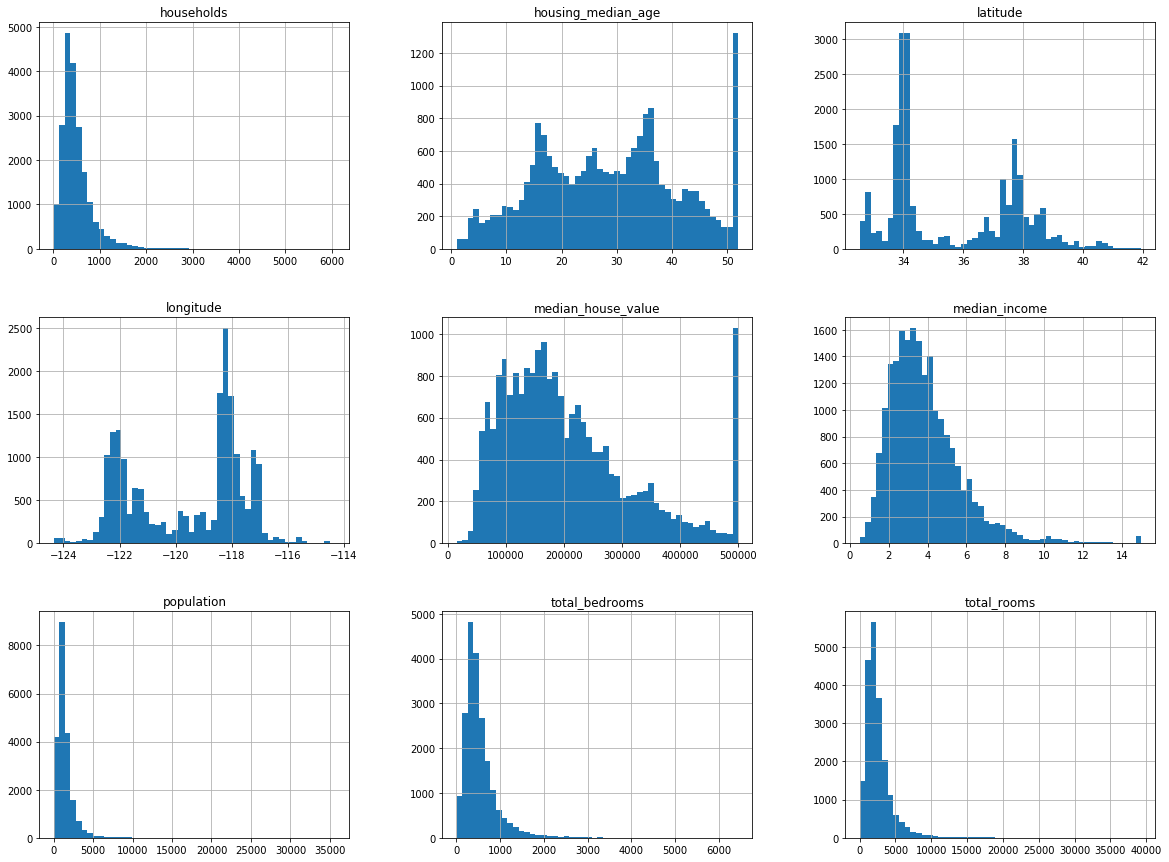

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Key insights from the histograms above:
1. The median_income seems to be small and short ranged. It is highly unlikely that it was expressed in US dollars (USD). It has been scaled and capped (range: 0.5 - 15)
2. The housing_median_age and the median_house_value were also capped. The latter can pose serious problems since it's our target attribute. To solve this issue, we could go back and collect proper data for the capped districts or we could remove those districts from the training set.
3. The attributes have very different scales. 
4. Many histograms are *tail heavy*: they extend much farther to the right of the median that to the left. We will try to do some transforming later on.

### 2.4. Creating a test set

#### 2.4.1. Random data split

By using **Scikit-Learn** we can randomly split our dataset and create a train set and a test set. The most common split leaves 20% for the testing and 80% for the training. We would keep the random state constant.

In [8]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### 2.4.2. Stratified data split

The purely random sampling method above is generally fine if the dataset is large enough (especially relative to the number of attributes), but if it is not, we run the risk of introducing a significant sampling bias. However, based on our domain knowledge, we know that the median income is a very important attribute to predict median housing prices. We can use this knowledge to ensure that the test set is representative of the various categories of income in the whole dataset. 

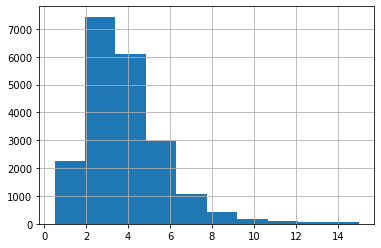

In [9]:
housing["median_income"].hist()

We can create 5 income categories, ranging from 1 to 5 with each individual category having a range of 1.5. The 5 categories would include the vast majority, but not all, of our median incomes. We want to make sure we limit the number of strata to avoid bias. we will used **pd.cut() function**. 

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

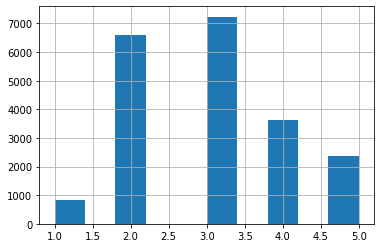

In [11]:
housing["income_cat"].hist()

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND,3
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND,3


We can now compare income categories between tests sets and the overall dataset after random sampling and stratified sampling.

In [13]:
def income_cat_propor(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_propor = pd.DataFrame({
    "Overall": income_cat_propor(housing),
    "Stratified": income_cat_propor(strat_test_set),
    "Random": income_cat_propor(test_set),
}).sort_index()

compare_propor["Rand. %error"] = 100 * compare_propor["Random"] / compare_propor["Overall"] - 100
compare_propor["Strat. %error"] = 100 * compare_propor["Stratified"] / compare_propor["Overall"] - 100

In [14]:
compare_propor

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


From the table above it is clear that the stratified sampling method has income category proportions almost identical to those in the full dataset, whereas the random test set is quite biased (skewed). We will used the stratified test set.

Now let's drop the *income_cat* column so the data is back to its original state.

In [15]:
for set_ in (strat_train_set, strat_test_set, housing):
    set_.drop("income_cat", axis=1, inplace=True)

In [16]:
train = strat_train_set.copy()
test = strat_test_set.copy()

## 3. Gaining Insights from Data

### 3.1. Visualizing geographical data

Since we have geographical information in our dataset (latitude and longitude), it is a good idea to creat a scatterplot of all districts to visualize the data.

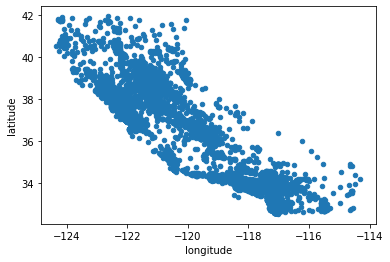

In [17]:
train.plot(kind="scatter", x="longitude", y="latitude")

There is no much information or pattern to gather from the plot above other than the fact that it looks like the map of California. Setting alpha to 0.1 would make it much easier to visualize the places where there is a high density of data points.

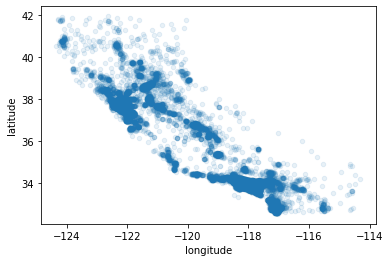

In [18]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Let's also look at the housing prices against our geographical data.

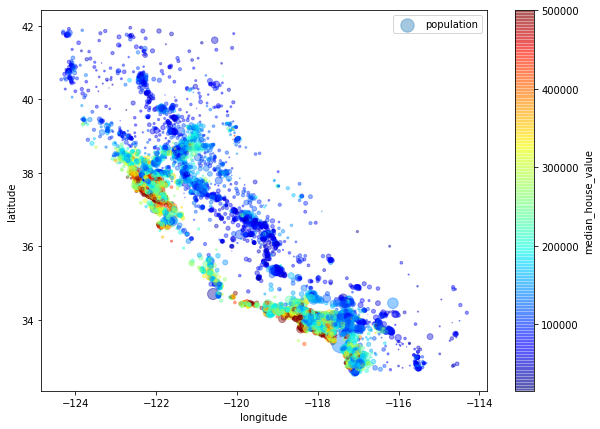

In [19]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
          s=train["population"]/100, label="population", figsize=(10,7),
          c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
          sharex=False)
plt.legend()

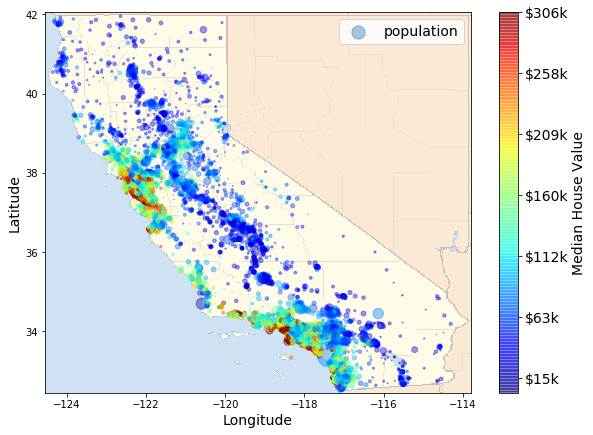

In [20]:
ax = train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
          s=train["population"]/100, label="population", figsize=(10,7),
          c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False
               )
cal_img = mpimg.imread("california.png")
plt.imshow(cal_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
          cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize=14)

plt.legend(fontsize=14)
plt.show()

The image above tells us that the housing prices are very much related to the location (e.g., close to the ocean)and to the population density. It would probably be useful if we used a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers.

### 3.2. Looking for correlations

To understand the correlations, we can easily compute the *standard correlation coefficient* (also called *Pearson's r*) between every pair of attribute using the **corr() method**. We can then look at how much each attribute correlates with the median house value.

In [21]:
corr_matrix = train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

As shown by the correlation table above, there is a strong positive correlation between median income and median house value. This is not surprising since we surmise this notion earlier on and used it to do stratified dataset splitting. It is important to know that the correlation coefficient only measures linear correlations; it may completely miss out on nonlinear correlations. 

Another way to check correlation between attributes is to use Pandas' **scatter_matrix function**, which plots every numerical attribute against every other numerical attribute. Let's focus on the top 4 promising attributes that seem most correlated with the median housing value.

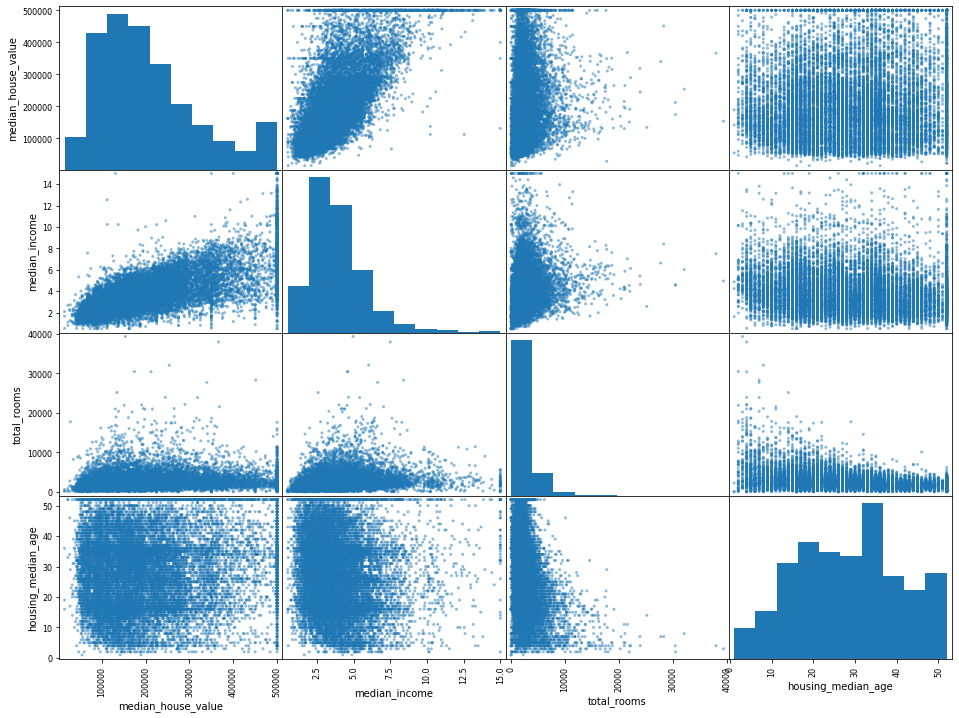

In [22]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(train[attributes], figsize=(16, 12))
plt.show()

The main diagonal (top left to bottom right) would be full of straight lines if Pandas plotted each variable against itself; this would not be useful at all. So instead Pandas displays a histogram of each attribute.

Since the most promising attribute to predict the median house value is the median income, let's zoom in on their correlation scatterplot.

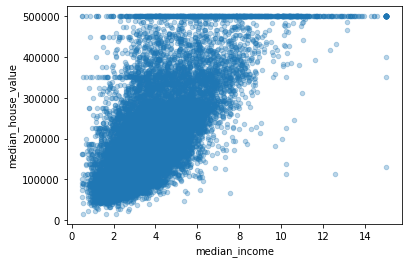

In [23]:
train.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.3)

This plot reaveals a few things:
1. The correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed
2. The price cap we noticed earlier is clearly visible as a horizontal line at USD 500,000. 
3. The plot reaveals other less obvious straight line at 450,000, 350,000, and perhaps one at around 280,000. There may even be more below. We may want to try to clean out the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

### 3.3. Experimenting with attribute combinations

One last thing we want to de before preparing data for Machine Learning algorithms is to try out various attribute combinations to see if we can improve the correlations. For example, the total number of rooms in a district is not very useful if we don't know how many households there are. What we really want is the number of rooms per household. Similarly, we want to know the number of bedrooms in each room and the population per household.

In [24]:
train["rooms_per_household"] = train["total_rooms"] / train["households"]
train["bedrooms_per_room"] = train["total_bedrooms"] / train["total_rooms"]
train["population_per_household"] = train["population"] / train["households"]

In [25]:
corr_matrix = train.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

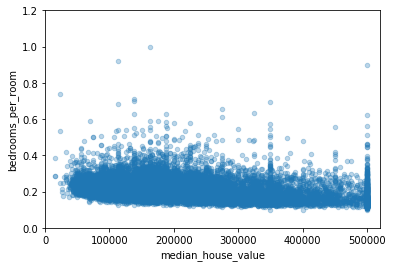

In [26]:
train.plot(kind="scatter", y="bedrooms_per_room", x="median_house_value", alpha=0.3)
plt.axis([0, 520000, 0, 1.2])
plt.show

Not bad! The new bedroom_per_room attribute is much more correlated (negatively) with the median house value than the total number of rooms or bedrooms. This makes sense because the lower the bedroom/room ratio the more expensive a house will be. The rooms_per_household attribute also improved our insight a bit. The larger the houses, the more expensive they are. 

## 4. Preparing Data for Machine Learning

It's now time to prepare the data for our Machine Learning algorithms; but first, let's separate the predictor columns and the label or target column since we don't necessarily want to apply the same transformations to them. Note that the **drop() function** creates a copy of the data and does not affect *strat_train_set*.

In [27]:
train = strat_train_set.drop("median_house_value", axis=1)
target = strat_train_set["median_house_value"].copy()

### 4.1. Data cleaning: numerical attributes

As mentioned earlier, the column total_bedrooms has some missing values. We need to fix this because most Machine Learning algorithms cannot work with missing features. We have 3 options to deal will missing values:
1. Get rid of the corresponding disctricts. This removes any rows with missing values anywhere. The problem: we end up with a smaller dataset
2. Get rid of the whole attribute. This removes the column with missing data
3. Set the values to some value. It can be zero, the mean, the median, the mode, etc. 

Let's explore all these options to see what happens. 

In [28]:
# Create a dataset with missing values anywhere
incomplete_rows = train[train.isnull().any(axis=1)].copy()
incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [29]:
# Option 1: Remove any rows with missing values. Dataset is empty!
incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [30]:
# Option 2: Remove column with missing values
incomplete_rows.drop("total_bedrooms", axis=1)
incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [31]:
# Option 3: Fill missing values with the median
median = train["total_bedrooms"].median()
incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


**Option 3 Using Scikit-Learn *SimpleImputer* Class**: 
- First, we will drop the text column because we can only compute the median on numerical attributes
- Second, we will fit the imputer to the training data. The imputer stores the computed median results into its *statistics_*
- Third, we replace missing values in our training set by the learned medians
- Fourth, we can put our transformed data back into a Pandas DataFrame. 
This strategy is much better than dealing with missing values separately because we can use our imputer stored values in our test set too. 

In [32]:
train_num = train.drop("ocean_proximity", axis=1)  # 3.1 drop text column
imputer = SimpleImputer(strategy="median")  # 3.2 use the imputer
imputer.fit(train_num)
print(imputer.statistics_)
print(train_num.median().values) # compare imputer statistics with manual values

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [33]:
X = imputer.transform(train_num)  # 3.3 impute medians into missing values
train_imp = pd.DataFrame(X, columns=train_num.columns, index=train.index) # 3.4 New DataFrame
print(imputer.strategy)
train_imp.head()

median


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [34]:
train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### 4.2. Handling text and categorical attributes

Our dataset has one column that is a categorical attribute, *ocean_proximity*. We left it out when we were computing medians because it would not be possible to get a median for a text column. Since most Machine Learning algorithms prefer to work with numbers anyway, we are going to convert this column from text to numbers by using Scikit-Learn's **OrdinalEncoder() class**.

In [35]:
train_cat = train[["ocean_proximity"]]
ord_encoder = OrdinalEncoder()
train_cat_encoded = ord_encoder.fit_transform(train_cat)
print(ord_encoder.categories_)
train_cat_encoded[:10]

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

The issue with this representation is that Machine Learning algorithms will assume that two nearby values are more similar than two distant values, which may be fine in some cases but not here. A common solution to this is to create one binary attribute per catergory (0 and 1). This is called *one-hot encoding*, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy* attributes. The ouptut is a SciPy sparse matrix, instead of a NumPy array, which is useful when you have thousands of categories and you don't want to use a ton of space to store a bunch of zeros. A **sparse matrix only stores the location of the non-zero elements**. 

In [36]:
cat_encoder = OneHotEncoder()
train_dummies = cat_encoder.fit_transform(train_cat)
print(cat_encoder.categories_)
train_dummies

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### 4.3. Custom transformers

Below we create a function transformer that adds the combined attributes we discussed earlier:

In [37]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(train.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")
]
def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
train_extra_attribs = attr_adder.fit_transform(train.values)

In [38]:
cols = list(train.columns) + ["rooms_per_household", "population_per_household"]
train_extra_attribs = pd.DataFrame(
    train_extra_attribs, columns=cols, index=train.index
)
train_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### 4.4. Transformation pipelines

Next we are going to use Scikit-Learn's **pipeline class** to help us with the sequences of transformations that we need to do before training a model. The pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. When the fit() method is called, the pipeline calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the fit() method. 

Let's start with the pipeline for the numerical attributes:

In [39]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attr_adder', FunctionTransformer(add_extra_features, validate=False)),
    ('std_scaler', StandardScaler())
])
train_num_tr = num_pipe.fit_transform(train_num)
train_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

#### Feature Scaling

There are two common ways to get all attributes to have the same scale:

1. *min-max scaling*: (also called *normalization*) values are shifted and rescaled so that they end up ranging from 0 to 1. This is done by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called **MinMaxScaler** for this. It has a *feature_range* hyperparameter that allows changing the range from 0-1 to something else.


2. *standardization*: subtracts the mean value (so standardized values always have a zero mean), and it divides by the standard deviation so that the resulting distribution has unit variance. Values are not bound to any specific range, which can be problematic for some algorithms like neural networks. However, standardization is less affected by outliers. 

We used standardization in our numerical pipeline above.

#### Column Transformation

So far, we have handled the numerical columns and categorical column separately. We can use Scikit-Learn's **ColumnTransformer** to handle all columns, applying the appropriate transformations to each column. Here is how it works:
- We get the list of numerical and the list of categorical column names
- We construct a ColumnTransformer which requires a list of tuples: name, transformer, and list of names/indices of columns

In [40]:
num_cols = list(train_num)
cat_cols = ["ocean_proximity"]

full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

train_ready = full_pipe.fit_transform(train)
train_ready.shape

(16512, 16)

In [41]:
train_ready

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## 5. Selecting and Training a Model

### 5.1. Training and evaluating on the training set

#### Linear Regression Model

In [42]:
linear_reg = LinearRegression()
linear_reg.fit(train_ready, target)
linear_predictions = linear_reg.predict(train_ready)
linear_mse = mean_squared_error(target, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(target, linear_predictions)
print("Linear_RMSE =", linear_rmse)
print("Linear_MAE =", linear_mae)

Linear_RMSE = 68628.19819848923
Linear_MAE = 49439.89599001897


It looks like our model isn't performing very well (large errors) probably due to underfitting. This usually means that the features do not provide enough information to make good predictions, or that the model is not powerful enough. 

Let's try a different model, a *DecisionTreeRegressor*. This is a powerful model, capable of finding complex nonlinear relationship in the data.

#### Decision Tree Model

In [43]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_ready, target)
tree_predictions = tree_reg.predict(train_ready)
tree_mse = mean_squared_error(target, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(target, tree_predictions)
print("Tree_RMSE =", tree_rmse)
print("Tree_MAE =", tree_mae)

Tree_RMSE = 0.0
Tree_MAE = 0.0


It's surprising that the decision tree model has no error at all. It is most likely because the model overfit the data. How can we be sure? We can do cross-validation to check. As a rule, we don't want to touch the test set until we are ready to launch a model we are confident about. That means, we use the training set for model training and model validation.

### 5.2. Using cross-validation for model evaluation

#### Decision Tree Cross-Validation

In [44]:
tree_scores = cross_val_score(tree_reg, train_ready, target, 
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean()),
    print("Std_dev:", scores.std())

display_scores(tree_rmse_scores)    

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Std_dev: 2439.4345041191004


The Decision Tree doesn't look as good as before. In facts, it's horrendous. Even worse than the linear regression we performed earlier. The one good thing about cross-validation is that it allows us to get an estimate of the performance of our model but also a measure of how precise that estimate is (i.e., its standard deviation). Now, let's do cross-validation on a Linear Regression model. 

#### Linear Regression Cross-Validation

In [45]:
linear_scores = cross_val_score(linear_reg, train_ready, target, 
                         scoring="neg_mean_squared_error", cv=10)
linear_rmse_scores = np.sqrt(-linear_scores)
display_scores(linear_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Std_dev: 2731.674001798349


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model. 

#### Random Forest Model

The RandomForestRegressor model work by training many Decision Trees on random subsets of the features, then averaging out their predictions. 

In [46]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(train_ready, target)
forest_predictions = forest_reg.predict(train_ready)
forest_mse = mean_squared_error(target, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [47]:
forest_scores = cross_val_score(forest_reg, train_ready, target,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Std_dev: 2298.353351147122


Random Forest looks much better, very promising. However, the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. We could try a few more models to see if we can find more promising ones before we tweak the hyperparameters.

## 6. Fine-Tuning Promising Models

### 6.1. Grid Search

By using Scikit-Learn's *GridSearchCV*, we can evaluate all the possible combinations of hyperparameter values, using cross-validation. For exampble the following code searches for the best combination of hyperparameter values for the RandomForestRegressor by trying 
- 24 (3x4x2) combinations of hyperparameters, and 
- then train across 5 folds, which means a total of 24x5=120 rounds of training

In [48]:
param_grid = {
    'n_estimators': [3, 10, 30], 
    'max_features': [2, 4, 6, 8],
    'bootstrap': [True, False]
}
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_ready, target)

print("Best hyperparameter combination:", grid_search.best_params_)

Best hyperparameter combination: {'bootstrap': False, 'max_features': 8, 'n_estimators': 30}


In [49]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [50]:
grid_results = grid_search.cv_results_
for mean_score, params in zip(grid_results["mean_test_score"], grid_results["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'bootstrap': True, 'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'bootstrap': True, 'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'bootstrap': True, 'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'bootstrap': True, 'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'bootstrap': True, 'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'bootstrap': True, 'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'bootstrap': True, 'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}

By fine-tuning our Random Forest Regressor model with GridSearchCV, we found the best solution by setting the **bootstrap to False, max_features to 8, and n_estimators to 30**. The **RMSE is 48,884**, which is better than than the score we got earlier using default hyperparameter valuers (which was 52,584). We have successfully fine-tuned our best model!

### 6.2. Randomized Search

When exploring a few combinations of hyperparameters, the grid search approach is fine. However, when the search space is large, it can take a long time to run; we use instead *RandomizedSearchCV*, which evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
- If we let the randomized search run for 1000 iterations, for example, it will explore 1000 different values for each hyperparameter instead of just a few we would get when using the grid search approach
- We have more control over the computing budget we want to allocate to hyperparameter search, simply by setting the number of iterations

In [51]:
random_params = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=12)
}
forest_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(forest_reg, param_distributions=random_params,
                                  n_iter=10, cv=5, scoring='neg_mean_squared_error'
                                  )
random_search.fit(train_ready, target)

random_results = random_search.cv_results_
for mean_score, params in zip(random_results["mean_test_score"], random_results["params"]):
    print(np.sqrt(-mean_score), params)

55895.52462470793 {'max_features': 1, 'n_estimators': 28}
50344.720977911806 {'max_features': 3, 'n_estimators': 198}
52243.03120763529 {'max_features': 10, 'n_estimators': 10}
49540.327440179724 {'max_features': 10, 'n_estimators': 155}
49487.92063352061 {'max_features': 5, 'n_estimators': 136}
49456.98836174629 {'max_features': 10, 'n_estimators': 188}
49357.06321845526 {'max_features': 5, 'n_estimators': 180}
52670.483385439635 {'max_features': 2, 'n_estimators': 45}
51714.83329481775 {'max_features': 11, 'n_estimators': 12}
49601.58818314031 {'max_features': 9, 'n_estimators': 66}


### 6.3. Analyzing the Best Models and Their Errors

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions.

In [52]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([7.88273169e-02, 6.88671378e-02, 4.19942712e-02, 1.49017795e-02,
       1.35027000e-02, 1.37463931e-02, 1.38703967e-02, 3.65660516e-01,
       5.60550742e-02, 1.06803673e-01, 4.91984306e-02, 6.03551591e-03,
       1.65945461e-01, 5.87295283e-05, 1.75702503e-03, 2.77557978e-03])

We can then display these importance scores next to their corresponding attribute names

In [53]:
extra_cols = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipe.named_transformers_['cat']
cat_cols = list(cat_encoder.categories_[0])
attributes = num_cols + extra_cols + cat_cols
sorted(zip(feature_importance, attributes), reverse=True)

[(0.36566051578935854, 'median_income'),
 (0.16594546121887757, 'INLAND'),
 (0.10680367278788902, 'pop_per_hhold'),
 (0.0788273168564426, 'longitude'),
 (0.06886713775077481, 'latitude'),
 (0.056055074188628866, 'rooms_per_hhold'),
 (0.049198430598853135, 'bedrooms_per_room'),
 (0.041994271206875156, 'housing_median_age'),
 (0.0149017794968775, 'total_rooms'),
 (0.013870396699546922, 'households'),
 (0.013746393149146328, 'population'),
 (0.013502700011651837, 'total_bedrooms'),
 (0.006035515910948288, '<1H OCEAN'),
 (0.002775579776224739, 'NEAR OCEAN'),
 (0.0017570250296167344, 'NEAR BAY'),
 (5.872952828798226e-05, 'ISLAND')]

The information above gives us something to think about. For example, it looks like only one ocean_proximity category is really useful; we could try to drop the others and see if it will improve our model. It would also be important to try to understand why our system is making some errors and how to improve either by adding more features or removing them. 

## 7. Evaluating the Best Model on the Test Set

In [54]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()

X_test_ready = full_pipe.transform(X_test)
test_predictions = final_model.predict(X_test_ready)
test_mse = mean_squared_error(Y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

print("Test_RMSE:", test_rmse)

Test_RMSE: 46994.8202174666


Let's compute a 95% confidence interval for the Test_RMSE.

In [55]:
confidence = 0.95
squared_errors = (test_predictions - Y_test) ** 2
mean_ = squared_errors.mean()
m = len(squared_errors)
confid_interv = np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))
print("Confidence_Interval_95%:", confid_interv)

Confidence_Interval_95%: [44979.05842307 48927.60527472]


In this California housing project, the final performance of the system might not be better than the experts', but it may still be a good idea to launch it, especially if this frees up some time for the experts so they can work on more interesting and productive tasks. 

### Conclusion

This was an excellent challenge. A lot was learned. I will definitely be coming back to it to refresh my memory on some of the new tools I used. It would be great to find a challenge on *kaggle.com* that has a dataset similar to this one but with a competition added to it. 